##### Group 34: Advanced Machine Learning Methods

Lucero Guadalupe Contreras Hernández - 

Javier de Alba Pérez - A01226046

Kevin Brandon Cruz Mejía - 

Armando Isaac Cruz García - 

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
# Importing needed libraries for the project

import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# Reading data from csv files

train_df = pd.read_csv("C:/Users/jdap_/OneDrive/Documentos/MNA/Deep Learning/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv('C:/Users/jdap_/OneDrive/Documentos/MNA/Deep Learning/asl_data/sign_mnist_valid.csv')

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Here we can see an example of the data and its shape.

### Import Images

In [4]:
# In the next cells we split our data into the groups that we will use for training, testing and validation.

y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    row_num = int(len(x) * pct)
    x_train = x[:row_num]
    x_test = x[row_num:]
    y_train = y[:row_num]
    y_test = y[row_num:]
    return x_train, y_train, x_test, y_test

In [6]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [7]:
# The following lines help us get the list of letters we are trying to predict

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalize

In [8]:
# In the following cells we normalize our data to avoid bias

def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [9]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalize(x_mean, x_std, x_train)
x_val = normalize(x_mean, x_std, x_val)
x_test = normalize(x_mean, x_std, x_test)

### Graphing samples

In [10]:
# This helper function graphs the image created from a sample

def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

### Equations for our model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Additional functions

#### Mini batches

In [11]:
# This function creates batches for the specifized size

def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Linear, ReLU, and Sequential classes

In [12]:
# This is a dummy class that inherits the np.ndarray class.

class np_tensor(np.ndarray): pass

###  Linear Class

In [13]:
# Creating our class for a linear layar that allows forward and backward propagation.

class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)  

### ReLU Class

![Alt text](image.png)

In [14]:
# Class to create the ReLU activation function for our layer.

class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Sequential Class

In [15]:
# Our class for the type of model. This layout acceps the different types of layers, which will advance sequentially.

class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))       

### Cost Function

In [16]:
# We define our cost funtion using the softmax entropy function

def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Accuracy Function

In [17]:
# We define our accuracy funtion for the training epochs

def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.T.view(np_tensor))
        total += pred.shape[1]
    return correct/total

### Training Loop

In [18]:
# We define the training process, iterating through the defined number of epochs and showing the cost and accuracy for each epoch

def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

### Create your model and train it

In [19]:
# After testing different values for the parameters, these values were chosen.

size = 200

model = Sequential_layers([Linear(784, size), ReLU(), Linear(size, size), ReLU(), Linear(size, size*2), ReLU(), Linear(size*2, 24)])
mb_size = 256
learning_rate = 1e-4
epochs = 30

train(model, epochs, mb_size, learning_rate)

costo: 0.7051763128224605, accuracy: 0.5948131622978249
costo: 0.33304453420112484, accuracy: 0.668153931957613
costo: 0.16837199289669716, accuracy: 0.6974344673731177
costo: 0.07065986548374745, accuracy: 0.6979921918572225
costo: 0.04901617264394866, accuracy: 0.7124930284439487
costo: 0.04517013930622379, accuracy: 0.7189068600111544
costo: 0.025341214700479387, accuracy: 0.7152816508644729
costo: 0.02392661449520424, accuracy: 0.7225320691578361
costo: 0.026678687901278596, accuracy: 0.72643614054657
costo: 0.01405097441662953, accuracy: 0.7281093139988846
costo: 0.014918978583337203, accuracy: 0.7378694924707194
costo: 0.011700052862335684, accuracy: 0.7342442833240379
costo: 0.012551316596589092, accuracy: 0.7356385945343
costo: 0.013935415378036284, accuracy: 0.7378694924707194
costo: 0.009515719794256632, accuracy: 0.7440044617958729
costo: 0.0073469563838651445, accuracy: 0.7412158393753486
costo: 0.006530815201393314, accuracy: 0.739542665923034
costo: 0.004393215101437615, 

We are getting around 75% accuracy value, which means that we will correctly predict 3 out of every 4 image signs.

We selected this architecture because it provided the best results of the tests that we created.

### Test your model on Random data from your test set

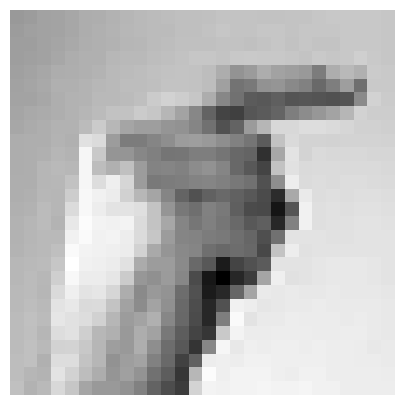

Predicted value: g 
Real value:g


In [21]:
# We plot an image, show the prediction and the actual value.

idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'Predicted value: {alphabet[pred]} \nReal value:{alphabet[y_test[idx]]}')